# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Цель работы:** построить модель, определяющую по фотографии приблизительный возраст человека.

**Ход работы:**
1. Исследовательский анализ данных;
2. Обучение модели;
3. Анализ обученной модели.

## Исследовательский анализ данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Загрузим и изучим данные.

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В выборке 7591 запись, пропуски отсутствуют. Посмотрим на распределение возрастов в выборке.

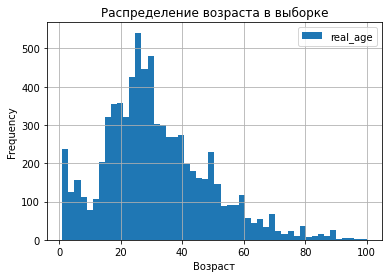

In [4]:
ax = data.plot(kind='hist', 
               y='real_age',
               bins=50,
               title='Распределение возраста в выборке',
               grid=True)
ax.set(xlabel='Возраст');

В выборке находится информация о фотографиях людей возрастом от 0 до 100 лет. Большая часть фото - фото людей примерно 20-30 лет. Также можно заметить, что среди детей больше всего фото младенцев, и что фотографий людей пожилого возраста в выборке меньше всего.

Посмотрим, как устроен датасет, напечатем 15 фотографий на экране.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = data, 
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    batch_size = 15,
    class_mode = 'raw',
    seed = 12345)

Found 7591 validated image filenames.


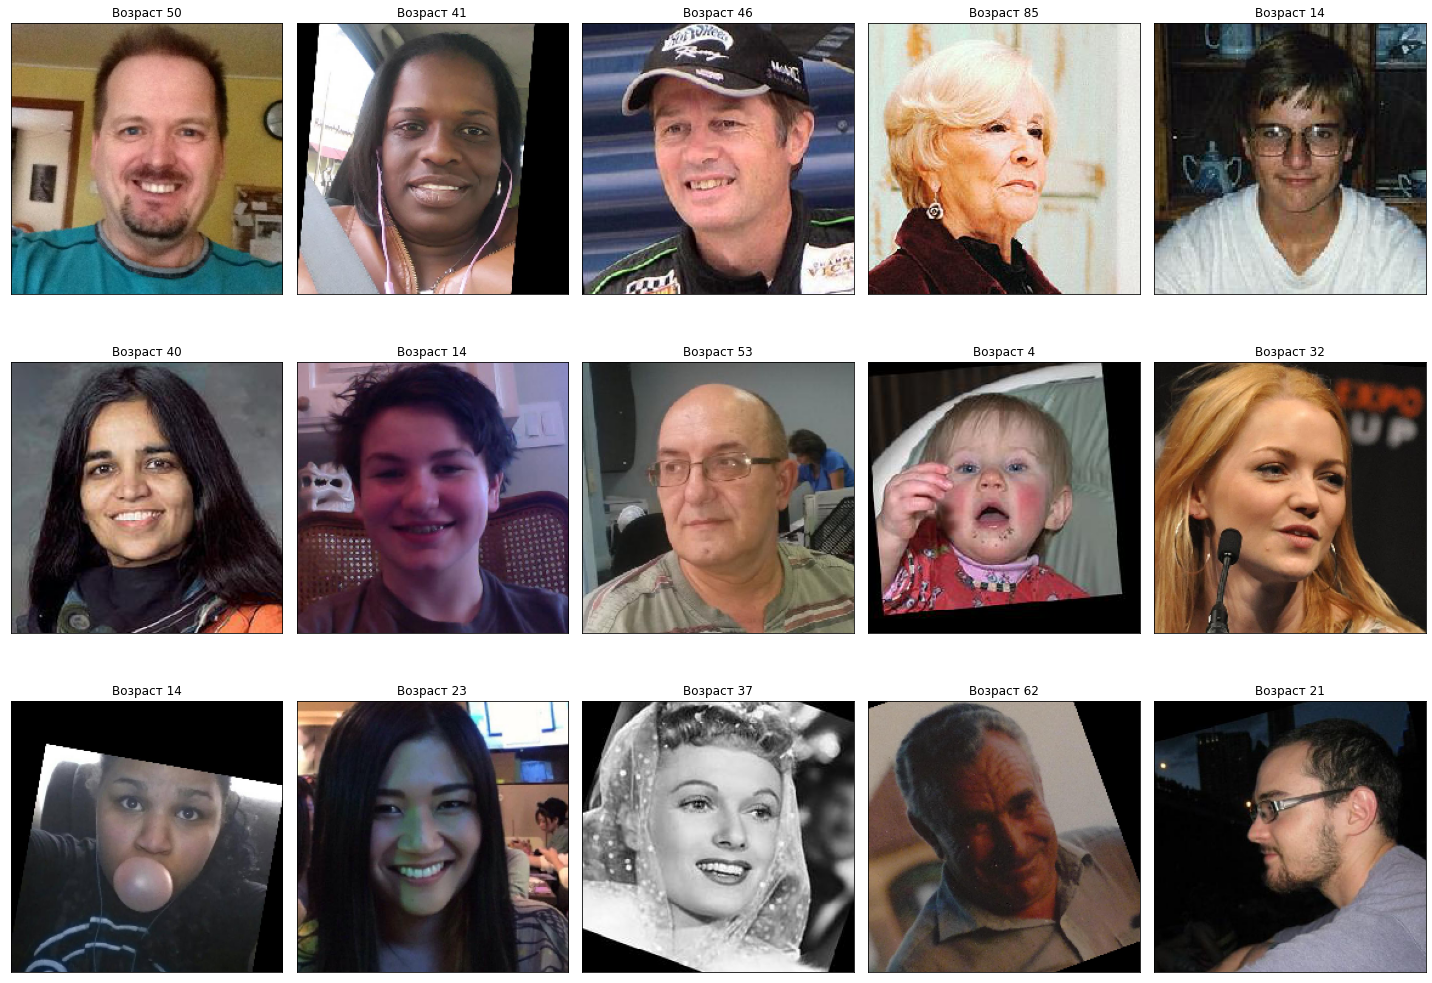

In [6]:
features, target = next(train_datagen_flow)
figure = plt.figure(figsize=(20, 16))
for i in range(15):
    figure.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст ' + str(target[i]))

В выборке есть перевернутые и сдвинутые изображения, а также черно-белые изображения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
data = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = data, 
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset='training',
        seed = 12345)

    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = data, 
        directory = '/datasets/faces/final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)

    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0002)
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/8
2022-10-20 21:45:41.670464: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-20 21:45:42.044046: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 52s - loss: 10.4263 - mae: 10.4272 - val_loss: 16.1737 - val_mae: 16.1596
Epoch 2/8
356/356 - 41s - loss: 7.7039 - mae: 7.7043 - val_loss: 12.8198 - val_mae: 12.8079
Epoch 3/8
356/356 - 41s - loss: 6.6092 - mae: 6.6093 - val_loss: 7.1246 - val_mae: 7.1288
Epoch 4/8
356/356 - 42s - loss: 5.7491 - mae: 5.7490 - val_loss: 7.5403 - val_mae: 7.5420
Epoch 5/8
356/356 - 42s - loss: 5.2337 - mae: 5.2340 - val_loss: 7.2985 - val_mae: 7.3042
Epoch 6/8
356/356 - 42s - loss: 4.6377 - mae: 4.6376 - val_loss: 7.6247 - val_mae: 7.6290
Epoch 7/8
356/356 - 42s - loss: 4.3801 - mae: 4.3799 - val_loss: 6.5853 - val_mae: 6.5915
Epoch 8/8
356/356 - 42s - loss: 3.9554 - mae: 3.9549 - val_loss: 6.3986 - val_mae: 6.4085
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.3986 - mae: 6.4085
Test MAE: 6.4085

```

## Анализ обученной модели

Модель с архитектурой ResNet50 обучилась за 8 эпох, результат MAE на обучающей выборке 3.9549, на валидационной выборке 6.4085, то есть модель ошибается в среднем примерно на 6 лет. Есть небольшое переобучение, если подобрать параметры, можно добиться лучшего результата MAE, хотя требуемое качество достигнуто. 